#

# Sistem Inferensi Fuzzy dalam Klasifikasi Kualitas Air Minum
Anggota:
- Ariq Naufal Fadhlurrahman - 103012480010
- M. Agung Isra Narwin - 103012480038

In [83]:
# Import dependencies
import numpy as np 
import skfuzzy as fuzz 
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

## Data Preprocessing

In [75]:
# Load dataset
df = pd.read_csv('water_potability.csv')

# Menghapus kolom yang kosong
df = df.dropna()

# Ambil fitur yang digunakan untuk fuzzy system
features = ['ph', 'Solids', 'Turbidity']
target = 'Potability'


# Mengambil sample data dengan niali solids < 5000
# df = df[df['Solids'] < 5000]

df_sample = df.sample(n=200, random_state=42).reset_index(drop=True)

df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


## Rentang nilai

In [68]:
ph_area = np.arange(0, 14.1, 0.1) # pH Air
# solids_area = np.arange(0, 5001, 100) # Jumlah padatan terlarut
turbidity_area = np.arange(0, 11, 0.1) # Tingkat kekeruhan
potability_area = np.arange(0, 1.1, 0.1) # Potabilitas air

## Metode Mamdani

In [77]:
# Fuzzy input
ph = ctrl.Antecedent(ph_area, 'pH')
# solids = ctrl.Antecedent(solids_area, 'solids')
turbidity = ctrl.Antecedent(turbidity_area, 'turbidity')

# Fuzzy output
potability = ctrl.Consequent(potability_area, 'potability')

# Membership functions untuk pH
ph['low'] = fuzz.trimf(ph.universe, [0, 0, 6.5])
ph['normal'] = fuzz.trimf(ph.universe, [6.5, 7.5, 8.5])
ph['high'] = fuzz.trimf(ph.universe, [7.5, 14, 14])

# Membership functions untuk Jumlah padatan terlarut
# solids['low'] = fuzz.trimf(solids.universe, [0, 0, 1200])
# solids['medium'] = fuzz.trimf(solids.universe, [1000, 2500, 4000])
# solids['high'] = fuzz.trimf(solids.universe, [2500, 5000, 5000])

# Membership functions untuk Tingkat kekeruhan
turbidity['low'] = fuzz.trimf(turbidity.universe, [0, 0, 3])
turbidity['medium'] = fuzz.trimf(turbidity.universe, [2, 5, 8])
turbidity['high'] = fuzz.trimf(turbidity.universe, [7, 10, 10])

# Membership functions untuk Potabilitas air
potability['not_potable'] = fuzz.trimf(potability.universe, [0, 0, 0.5])
potability['maybe'] = fuzz.trimf(potability.universe, [0.4, 0.5, 0.6])
potability['potable'] = fuzz.trimf(potability.universe, [0.5, 1, 1])

# Rules
# rule1 = ctrl.Rule(ph['normal'] & solids['low'] & turbidity['low'], potability['potable'])
# rule2 = ctrl.Rule(ph['high'] & solids['medium'] & turbidity['medium'], potability['maybe'])
# rule3 = ctrl.Rule(ph['low'] & solids['high'] & turbidity['high'], potability['not_potable'])
rule1 = ctrl.Rule(ph['normal'] & turbidity['low'], potability['potable'])
rule2 = ctrl.Rule(ph['high'] & turbidity['medium'], potability['maybe'])
rule3 = ctrl.Rule(ph['low'] | turbidity['high'], potability['not_potable'])

potability_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
potability_sim = ctrl.ControlSystemSimulation(potability_ctrl)

def mamdani_inference(ph, turbidity):
    potability_sim.input['pH'] = ph
    # potability_sim.input['solids'] = solids
    potability_sim.input['turbidity'] = turbidity

    potability_sim.compute()
    return potability_sim.output['potability']

## Graf Membership Function

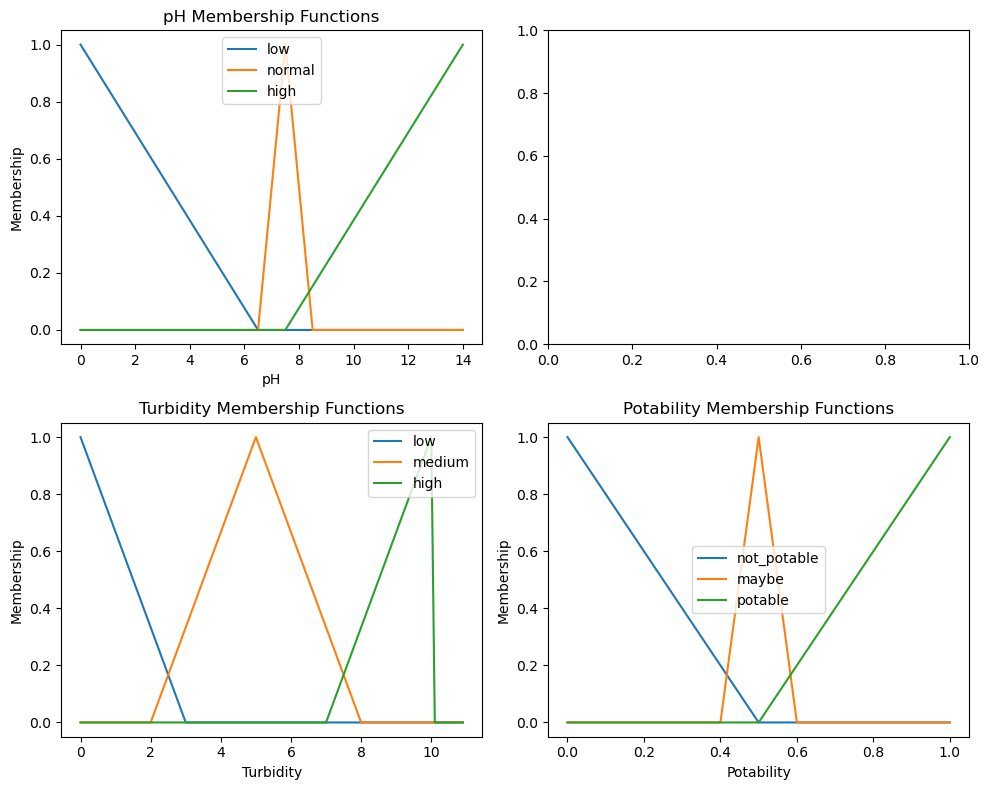

In [70]:
# Plotting the membership functions to grid
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# pH
for term in ph.terms:
	ax[0, 0].plot(ph.universe, ph[term].mf, label=term)
ax[0, 0].set_title('pH Membership Functions')
ax[0, 0].set_xlabel('pH')
ax[0, 0].set_ylabel('Membership')
ax[0, 0].legend()

# # Solids
# for term in solids.terms:
# 	ax[0, 1].plot(solids.universe, solids[term].mf, label=term)
# ax[0, 1].set_title('Solids Membership Functions')
# ax[0, 1].set_xlabel('Solids')
# ax[0, 1].set_ylabel('Membership')
# ax[0, 1].legend()

# Turbidity
for term in turbidity.terms:
	ax[1, 0].plot(turbidity.universe, turbidity[term].mf, label=term)
ax[1, 0].set_title('Turbidity Membership Functions')
ax[1, 0].set_xlabel('Turbidity')
ax[1, 0].set_ylabel('Membership')
ax[1, 0].legend()

# Potability
for term in potability.terms:
	ax[1, 1].plot(potability.universe, potability[term].mf, label=term)
ax[1, 1].set_title('Potability Membership Functions')
ax[1, 1].set_xlabel('Potability')
ax[1, 1].set_ylabel('Membership')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

## Metode Sugeno

In [71]:
def sugeno(ph_val, turb_val):
    # Keanggotaan kasar untuk contoh
    ph_norm = fuzz.interp_membership(ph_area, fuzz.trimf(ph_area, [6.5 ,7.5 ,8.5]), ph_val)
    # solids_low = fuzz.interp_membership(solids_area, fuzz.trimf(solids_area, [0, 0, 1200]), solids_val)
    turb_low = fuzz.interp_membership(turbidity_area, fuzz.trimf(turbidity_area, [0 , 0, 3]), turb_val)

    ph_low = fuzz.interp_membership(ph_area, fuzz.trimf(ph_area, [0, 0, 6.5]), ph_val)
    # solids_high = fuzz.interp_membership(solids_area, fuzz.trimf(solids_area, [2500, 5000, 5000]), solids_val)
    turb_high = fuzz.interp_membership(turbidity_area, fuzz.trimf(turbidity_area, [7, 10, 10]), turb_val)

    ph_high = fuzz.interp_membership(ph_area, fuzz.trimf(ph_area, [7.5 , 14, 14]), ph_val)
    # solids_med = fuzz.interp_membership(solids_area, fuzz.trimf(solids_area, [1000, 2500, 4000]), solids_val)
    turb_med = fuzz.interp_membership(turbidity_area, fuzz.trimf(turbidity_area, [2, 5, 8]), turb_val)

    rules = [
        # (min(ph_norm, solids_low, turb_low), 1.0),
        # (min(ph_low, solids_high, turb_high), 0.0),
        # (min(ph_high, solids_med, turb_med), 0.5)
        (min(ph_norm, turb_low), 1.0),
        (min(ph_low, turb_high), 0.0),
        (min(ph_high, turb_med), 0.5)
    ]

    num = sum(w*z for w,z in rules)
    den = sum(w for w,_ in rules)

    return num / den if den != 0 else 0.5

In [86]:
y_true = df_sampel[target].values
y_pred_mamdani = []
y_pred_sugeno = []

# Loop through the sample data
for _, row in df_sampel.iterrows():
    ph_val, turb_val = row[['ph', 'Turbidity']]

    # Get the output from Mamdani and Sugeno
    potability_mamdani = mamdani_inference(ph_val, turb_val)
    potability_sugeno = sugeno(ph_val, turb_val)

    # Append the results to the list
    y_pred_mamdani.append(1 if potability_mamdani >= 0.5 else 0)
    y_pred_sugeno.append(1 if potability_sugeno >= 0.5 else 0)

# Calculate accuracy and F1 score
accuracy_mamdani = accuracy_score(y_true, y_pred_mamdani)
accuracy_sugeno = accuracy_score(y_true, y_pred_sugeno)
f1_mamdani = f1_score(y_true, y_pred_mamdani)
f1_sugeno = f1_score(y_true, y_pred_sugeno)
recall_mamdani = recall_score(y_true, y_pred_mamdani)
recall_sugeno = recall_score(y_true, y_pred_sugeno)
precision_mamdani = precision_score(y_true, y_pred_mamdani)
precision_sugeno = precision_score(y_true, y_pred_sugeno)

print(f"Accuracy Mamdani: {accuracy_mamdani:.2f}, Accuracy Sugeno: {accuracy_sugeno:.2f}")
print(f"Recall Mamdani: {recall_mamdani:.2f}, Recall Sugeno: {recall_sugeno:.2f}")
print(f"Precision Mamdani: {precision_mamdani:.2f}, Precision Sugeno: {precision_sugeno:.2f}")
print(f"F1 Score Mamdani: {f1_mamdani:.2f}, F1 Score Sugeno: {f1_sugeno:.2f}")


Accuracy Mamdani: 0.62, Accuracy Sugeno: 0.38
Recall Mamdani: 0.00, Recall Sugeno: 1.00
Precision Mamdani: 0.00, Precision Sugeno: 0.38
F1 Score Mamdani: 0.00, F1 Score Sugeno: 0.55


C:\Users\ariqn\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
